# Deep Learning for Computer Vision:  HW 2


## Computer Science: COMS W 4995 004


## Due: October 13, 2020

#### Problem

You are given the noisy XOR data generated for you below. Your task is to implement a multi-layer perceptron binary classifier with one hidden layer. For the activiation function of the hidden units use ReLu. For the loss function use a softplus on a linear output layer as we did in class.

a) Implement each layer of the network as a separate function with both forward propagation and backpropagation. 

b) Train the network using stochastic gradient descent with mini-batches.  

c) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the binary labels. 

d) Repeat (b) and (c) varying the number of hidden units: 3, 16, 512. Discuss how the number of hidden units effects the solution.

e) Try choosing your own loss function (without asking me or the TAs what you should choose), repeating (d).

f) Now try with three inputs, generating your own training and validation data. (For this XOR the output should be a 1 if and only if exactly one of the inputs is 1. But make the training data noisy as before.) Use softplus loss. Do not try to show the decision regions, instead generate a validation set in the same manner as the training set, classify the samples, and compute the classification accuracy.

g) Using your data from HW1 or any new data you curate, train your MLP using your training set (80%). Compute the error rate on your validation set (20%). It's up to you how many hidden units to use. 

If you are struggling to get the network to converge, experiment with different learning rates.

Grading: a-d = 65%, e=10%, f=5%, g=20%. 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.



Let's start by importing some libraries.

In [349]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

Let's make up some noisy XOR data.

In [476]:
data = pd.DataFrame(np.zeros((10000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    y = 1.0 * np.logical_xor(x1==1,x2==1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
        
data.head()

,x1,x2,y
0,0.038819,0.857723,1.0
1,-0.097076,0.623216,0.0
2,1.126040,1.132939,0.0
3,-0.149651,0.234264,0.0
4,1.129428,0.234805,1.0


Let's message this data into a numpy format.

In [477]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [478]:
# Sloppy function for plotting our data
def plot_data(X, y_prob):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Noisy XOR')
    plt.show()

Now let's plot it.

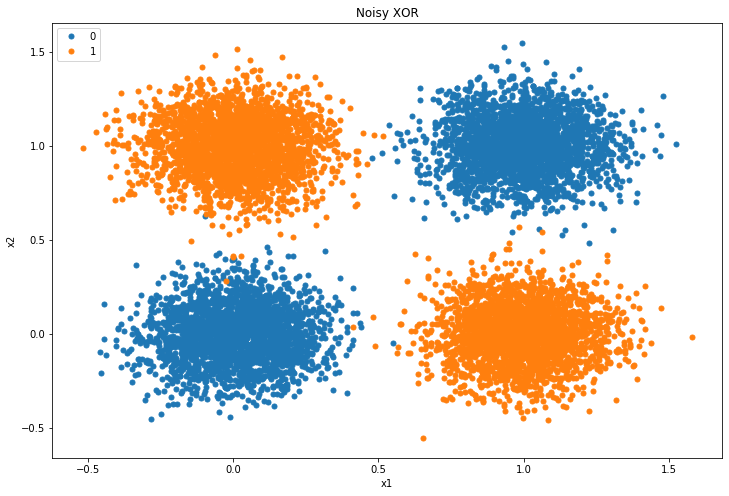

In [479]:
plot_data(X, y)

Now let's create functions for forward and backward prop through the layers and we are off...

In [480]:
# Create the relu and loss functions
import math
def relu(x):
    x1 = np.array(x)
    try:
        m, n = x1.shape
        for i, j in zip(range(m), range(n)):
            x1[i][j] = max(float(x1[i][j]), 0.0)
        return x1
    except ValueError:
        return [max(float(i), 0.0) for i in x1]

def softplus(x):
    return np.log(1.0 + np.exp(x))

def sigma(x):
    return 1.0 / (1.0 + np.exp(-x))

def softminus(x):
    return x - softplus(x)

In [481]:
# Define the functions for the layers
def forprop_hidden_layer(W, x, c):
    u2 = np.dot(W.T,x) + c
    return relu(u2)

def forprop_output_layer(w, h, b):
    u3 = np.dot(np.transpose(w), h)
    return u3 + b 

def forprop_loss_layer(y, z):
    u4 = (1.0 - 2.0*y)*z
    return softplus(u4)
    
def forward_propagation(x, y, W, c, w, b):
    h = forprop_hidden_layer(W, x, c)
    z = forprop_output_layer(w, h, b)
    L = forprop_loss_layer(y, z)

    return h, z, L

def backprop_loss_layer(y, z):
    u4 = (1.0-2.0*float(y))*z
    dldu4 = sigma(u4)
    du4dz = (1.0-2.0*float(y))
    
    return dldu4*du4dz

def backprop_output_layer(dldz, h, w):
    dldb = dldz
    dldu3 = dldz
    dldw = np.multiply(dldu3, h)
    dldh = np.multiply(dldu3, w)
    return dldb, dldw, dldh
    
def backprop_hidden_layer(dldh, x, W, c):
    a = np.dot(np.transpose(W), x) + c
    f = relu(np.dot(np.transpose(W), x) + c)
    dldc = np.multiply(f, dldh)
    # FIX LAYER BELOW BY MAKING IT HAVE THE RIGHT DIMENSIONS
    dldW = np.dot(x, np.multiply(f, dldh).T)
    
    return dldW, dldc

def backward_propogation(x, y, z, h, w, W, c):
    dldz = backprop_loss_layer(y, z)
    dldb, dldw, dldh = backprop_output_layer(dldz, h, w)
    dldW, dldc = backprop_hidden_layer(dldh, x, W, c)
    return dldW, dldc, dldw, dldb


In [482]:
# gradient descent algorithm
import math
def mini_batch(X, y, batch_size):
    n = math.ceil(X.shape[0] / batch_size)
    batches = []
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    indices = np.append(indices, indices) # Allows wrap around if there is a remainder
    batch = 0
    b = 0 
    while batch < n:
        batches.append(([X[indices[i]] for i in range(b, b+batch_size)],\
            [y[indices[i]].item(0) for i in range(b, b+batch_size)]))
        batch += 1 #iterate batch 
        b += batch_size # move b to right index
        
    return batches

def gradientDescent(x, y, W, c, w, b, iters, batch_size, lr):
    for _ in range(iters):
        for mini_x, mini_y in mini_batch(x, y, batch_size):
            for x_point, y_point in zip(mini_x, mini_y):
                h, z, L = forward_propagation(x_point.T, y_point, W, c, w, b)
                dldW, dldc, dldw, dldb = backward_propogation(x_point.T, y_point, z, h, w, W, c)
                W -= np.multiply(lr,dldW)
                c -= np.multiply(lr,dldc)
                w -= np.multiply(lr,dldw)
                b -= np.multiply(lr,dldb)
    return W, c, w, b

Part B


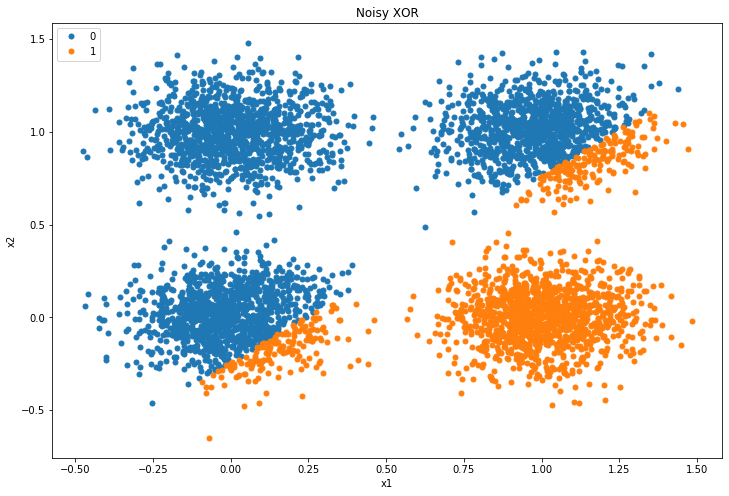

Part C


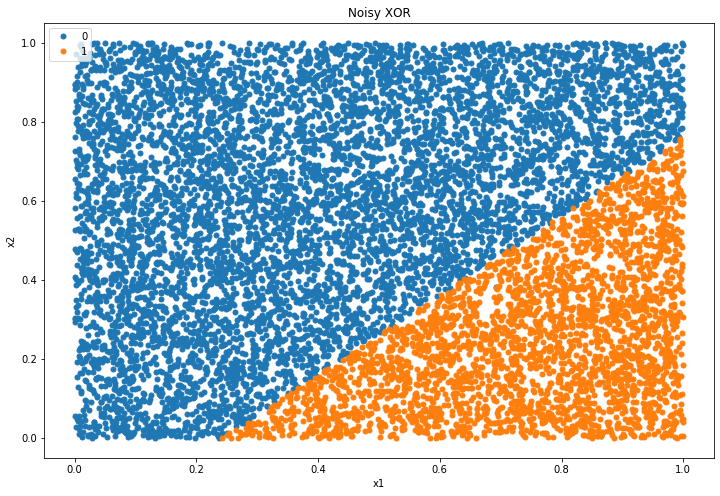

In [290]:
print("Part B")
W = np.random.random((2,2)) - .5
c = .1 * np.random.random((2, 1))
w = np.random.random((2, 1)) - .5
b = .1 * np.random.random()
lr = .001
iters = 100
W, c, w, b = gradientDescent(X, y, W, c, w, b, iters, 16, lr)
loss = np.zeros(X.shape[0])
y_predict= np.zeros(X.shape[0])
    
for i in range(X.shape[0]):
    h, z, loss[i] = forward_propagation(np.transpose(X[i, :]), y[i], W, c, w, b)
    y_predict[i] = sigma(z)
plot_data(X, y_predict)
    
print("Part C")
X_plot = np.matrix(np.random.random((10000, 2)))
y_plot = np.zeros(10000)
for i in range(X_plot.shape[0] - 1):
    h, z, L = forward_propagation(np.transpose(X_plot[i, :]), y_plot[i], W, c, w, b)
    y_plot[i] = sigma(z)
plot_data(X_plot, y_plot)

Training with 3 hidden units and lr 0.0001


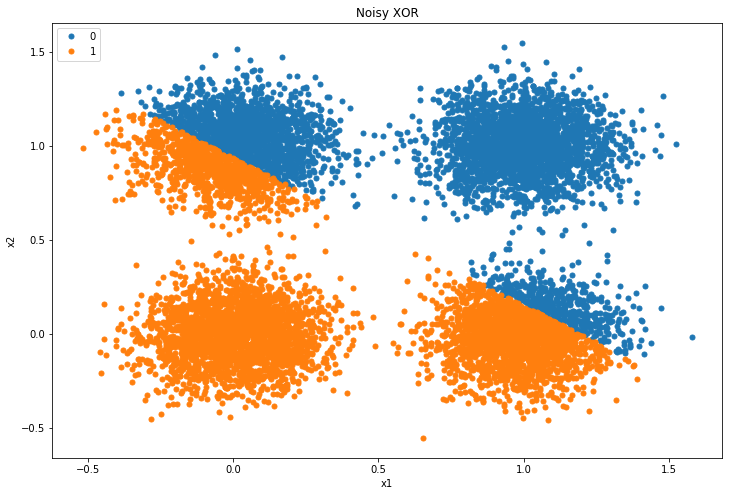

Training complete. Graphing Dense Plot


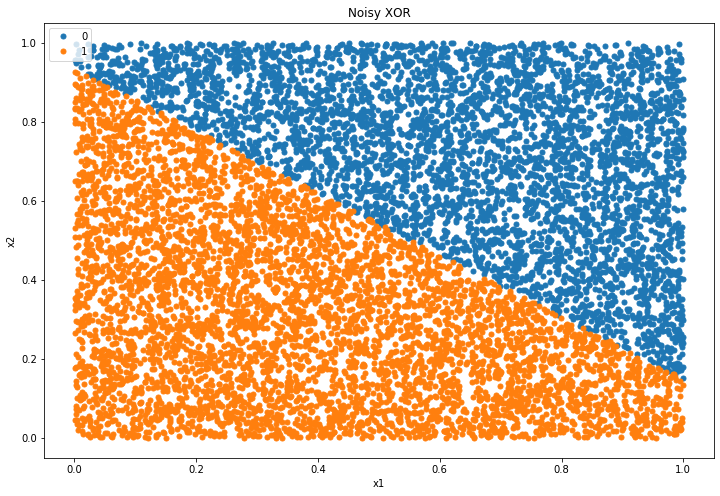

Training with 16 hidden units and lr 0.0001


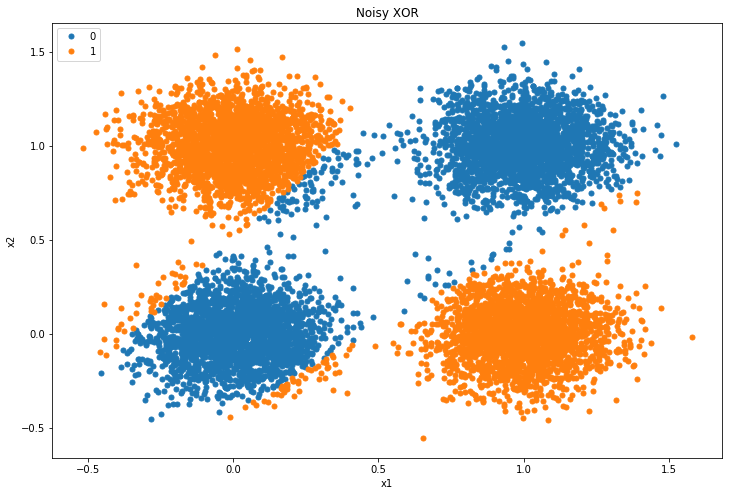

Training complete. Graphing Dense Plot


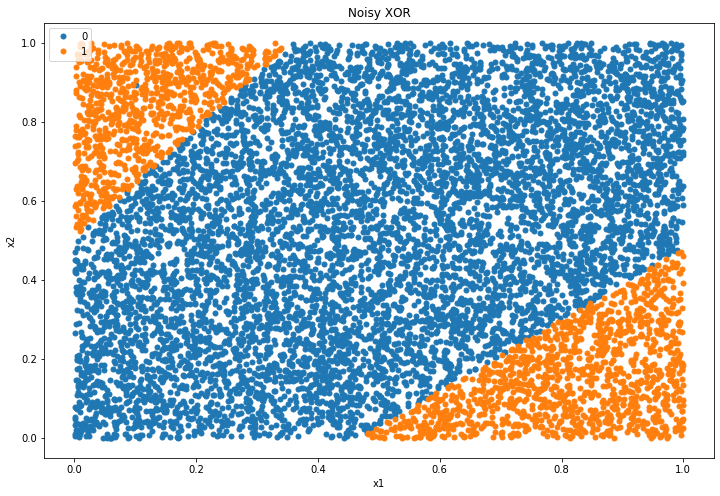

Training with 512 hidden units and lr 0.0001


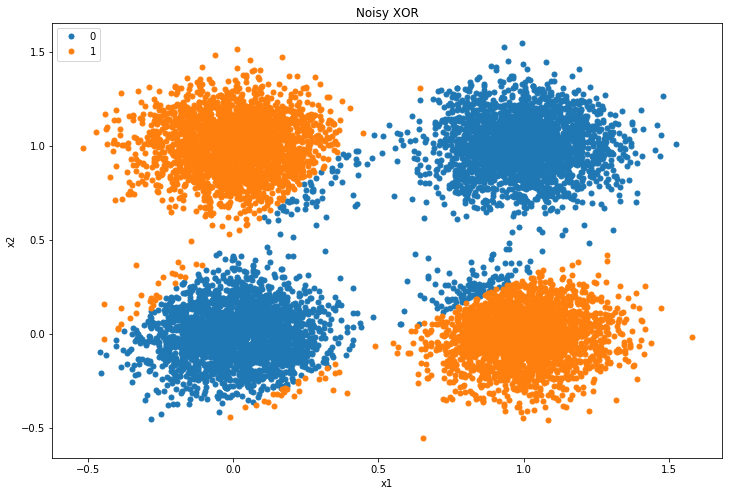

Training complete. Graphing Dense Plot


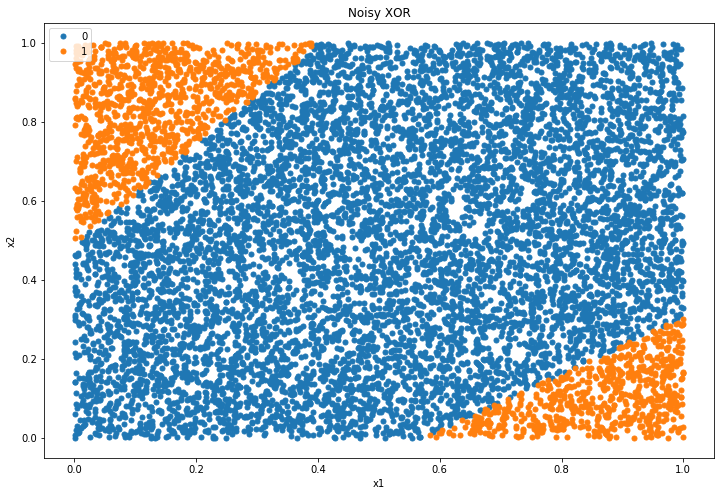

In [484]:
# part d: Initialize and run 
for hidden_units in [3, 16, 512]:
    W = np.random.random((2,hidden_units)) - .5
    c = .1 * np.random.random((hidden_units, 1))
    w = np.random.random((hidden_units, 1)) - .5
    b = .1 * np.random.random()
    lr = .0001
    iters = 100
    print("Training with %s hidden units and lr %s" %(hidden_units, lr))
    W, c, w, b = gradientDescent(X, y, W, c, w, b, iters, 32, lr)
    loss = np.zeros(X.shape[0])
    y_predict= np.zeros(X.shape[0])
    
    for i in range(X.shape[0]):
        h, z, loss[i] = forward_propagation(np.transpose(X[i, :]), y[i], W, c, w, b)
        y_predict[i] = sigma(z)
    plot_data(X, y_predict)
    
    print("Training complete. Graphing Dense Plot")
    X_plot = np.matrix(np.random.random((10000, 2)))
    y_plot = np.zeros(10000)
    for i in range(X_plot.shape[0] - 1):
        h, z, L = forward_propagation(np.transpose(X_plot[i, :]), y_plot[i], W, c, w, b)
        y_plot[i] = sigma(z)
    plot_data(X_plot, y_plot)

Increasing the number of units has a clear impact on the accuracy. Although, there also seems to be diminishing returns as the difference between 3 and 16 was bigger than the difference between 16 and 512.

In [410]:
# Part f, part e is below
print("Part F")
# Generate Training data
data = pd.DataFrame(np.zeros((5000, 4)), columns=['x1', 'x2', 'x3', 'y'])
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    x3 = 1.0 * random.randint(0,1)
    y = 0.0
    if x1+x2+x3 == 1:
        y = 1.0
    x1 += 0.15 * np.random.normal()
    x2 += 0.15 * np.random.normal()
    x3 += 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = x2
    data.iloc[i,3] = y
data.head()

Part F


,x1,x2,x3,y
0,-0.158578,1.041878,1.041878,0.0
1,1.103736,-0.250523,-0.250523,0.0
2,-0.107221,0.233687,0.233687,1.0
3,1.150988,1.111659,1.111659,0.0
4,1.473764,0.839434,0.839434,0.0


In [411]:
# Make 3d Data and divide into train and test set
cols = data.shape[1]
X = data.iloc[:,0:cols-1].values
y = data.iloc[:,cols-1:cols].values
X_train, y_train, X_test, y_test = [], [], [], []
indices = np.arange(len(X))
np.random.shuffle(indices)
for i in indices:
    if len(X_train) >= .8 * len(X):
        X_test.append(X[i])
        y_test.append(y[i])
    else:
        X_train.append(X[i])
        y_train.append(y[i])
# Convert to matrices 
X_test = np.matrix(X_test)
y_test = np.matrix(y_test)
X_train = np.matrix(X_train)
y_train = np.matrix(y_train)
print(X_test.shape, X_train.shape)
print(y_test.shape, y_train.shape)

(1000, 3) (4000, 3)
(1000, 1) (4000, 1)


In [412]:
W = np.random.random((3,16)) - .5
c = .1 * np.random.random((16, 1))
w = np.random.random((16, 1)) - .5
b = .1 * np.random.random()
lr = .001
iters = 100
W, c, w, b = gradientDescent(X_train, y_train, W, c, w, b, iters, 64, lr)
loss = np.zeros(X_train.shape[0])
y_predict= np.zeros(X.shape[0])
    
for i in range(X_train.shape[0]):
    h, z, loss[i] = forward_propagation(np.transpose(X_train[i, :]), y_train[i], W, c, w, b)
    y_predict[i] = sigma(z)
    
print("Training Complete, computing accuracy and loss")
y_prob = np.zeros(X_test.shape[0])
loss = np.zeros(X_test.shape[0])
for i in range(X_test.shape[0]):
    h, z, loss[i] = forward_propagation(np.transpose(X_test[i, :]), y_test[i], W, c, w, b)
    y_prob[i] = sigma(z)
y_pred = [float(round(prob)) for prob in y_prob]
correct = [int(y_pred[i]==y_test[i]) for i in range(len(y_pred))]
accuracy = sum(correct) / len(correct)
print("Accuracy :", accuracy)
print("Total Loss:", sum(loss))
print("Average Loss:", sum(loss)/len(loss))

Training Complete, computing accuracy and loss
Accuracy : 0.618
Total Loss: 602.3627264972092
Average Loss: 0.6023627264972092


In [467]:
# Part G
data = pd.read_csv("SenatorsFootSpeed.csv")
y = np.array(data.iloc[:, -1].values)
X = np.array([data.iloc[:, 6].values, data.iloc[:, 9].values]).T
X_train, y_train, X_test, y_test = [], [], [], []
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
for i in range(indices.shape[0]):
    if i >= .8*indices.shape[0]:
        X_test.append(X[indices[i]])
        y_test.append(y[indices[i]])
    else:
        X_train.append(X[indices[i]])
        y_train.append(y[indices[i]])
X_train = np.matrix(X_train)
y_train = np.matrix(y_train).T
X_test = np.matrix(X_test)
y_test = np.matrix(y_test).T
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(80, 2) (20, 2)
(80, 1) (20, 1)


In [468]:
W = np.random.random((2,16)) - .5
c = .1 * np.random.random((16, 1))
w = np.random.random((16, 1)) - .5
b = .1 * np.random.random()
lr = .000000000001
iters = 100
W, c, w, b = gradientDescent(X_train, y_train, W, c, w, b, iters, 64, lr)
loss = np.zeros(X_train.shape[0])
y_predict= np.zeros(X.shape[0])
    
for i in range(X_train.shape[0]):
    h, z, loss[i] = forward_propagation(np.transpose(X_train[i, :]), y_train[i], W, c, w, b)
    y_predict[i] = sigma(z)
    
print("Training Complete, computing accuracy and loss")
y_prob = np.zeros(X_test.shape[0])
loss = np.zeros(X_test.shape[0])
for i in range(X_test.shape[0]):
    h, z, loss[i] = forward_propagation(np.transpose(X_test[i, :]), y_test[i], W, c, w, b)
    y_prob[i] = sigma(z)
y_pred = [float(round(prob)) for prob in y_prob]
correct = [int(y_pred[i]==y_test[i]) for i in range(len(y_pred))]
accuracy = sum(correct) / len(correct)
print("Accuracy :", accuracy)
print("Loss :", sum(loss))

Training Complete, computing accuracy and loss
Accuracy : 0.35
Loss : 1527.7246101457754


In [465]:
# PART e

In [469]:
def forprop_hidden_layer(W, x, c):
    u2 = np.dot(W.T,x) + c
    return relu(u2)

def forprop_output_layer(w, h, b):
    u3 = np.dot(np.transpose(w), h)
    return u3 + b 

def forprop_loss_layer(y, z):
    u4 = (1.0 - 2.0*y)*z
    return softplus(u4)
    
def forward_propagation(x, y, W, c, w, b):
    h = forprop_hidden_layer(W, x, c)
    z = forprop_output_layer(w, h, b)
    L = forprop_loss_layer(y, z)

    return h, z, L

def backprop_loss_layer(y, z):
    u4 = (1.0-2.0*float(y))*z
    dldu4 = 1.0 - sigma(u4)
    du4dz = (1.0-2.0*float(y))
    
    return dldu4*du4dz

def backprop_output_layer(dldz, h, w):
    dldb = dldz
    dldu3 = dldz
    dldw = np.multiply(dldu3, h)
    dldh = np.multiply(dldu3, w)
    return dldb, dldw, dldh
    
def backprop_hidden_layer(dldh, x, W, c):
    a = np.dot(np.transpose(W), x) + c
    f = relu(np.dot(np.transpose(W), x) + c)
    dldc = np.multiply(f, dldh)
    dldW = np.dot(x, np.multiply(f, dldh).T)
    
    return dldW, dldc

def backward_propogation(x, y, z, h, w, W, c):
    dldz = backprop_loss_layer(y, z)
    dldb, dldw, dldh = backprop_output_layer(dldz, h, w)
    dldW, dldc = backprop_hidden_layer(dldh, x, W, c)
    return dldW, dldc, dldw, dldb



Part E
Training with hidden units 3 and learning rate 1e-08


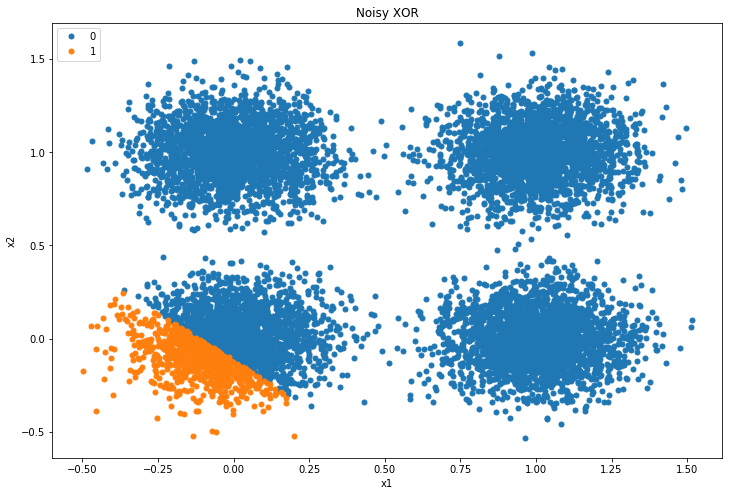

Training complete. Starting test


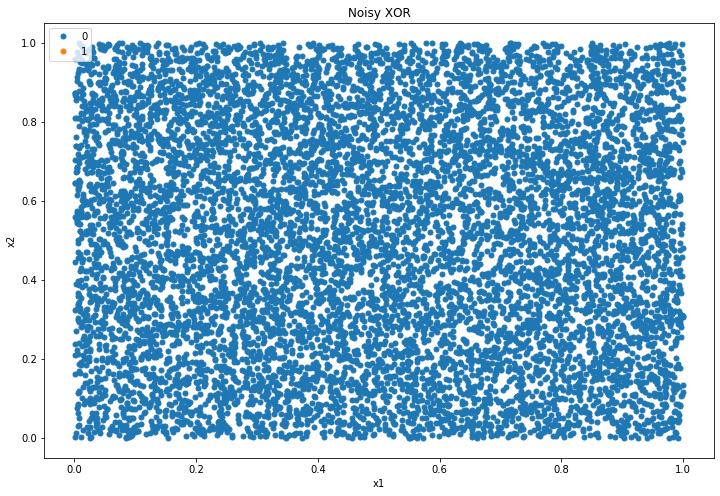

Training with hidden units 16 and learning rate 1e-08


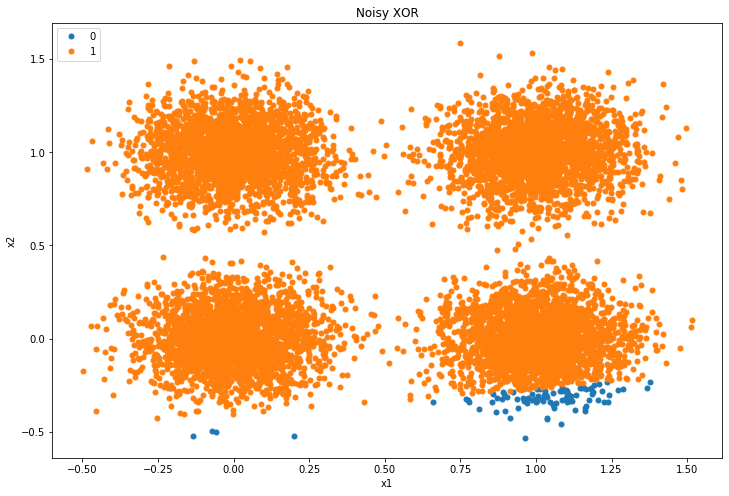

Training complete. Starting test


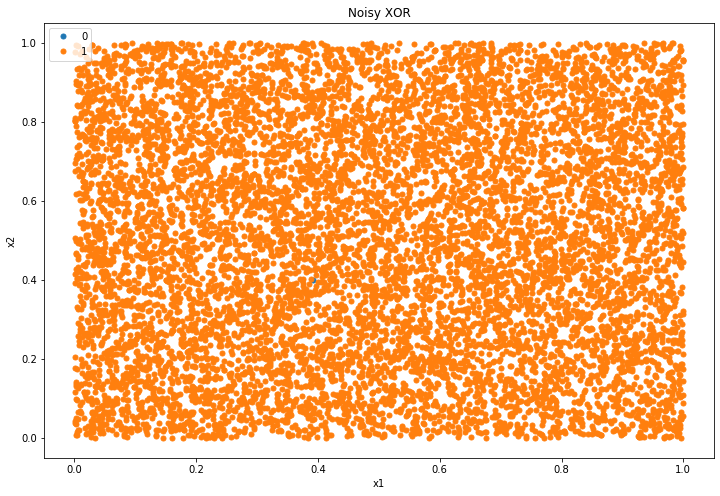

Training with hidden units 512 and learning rate 1e-08


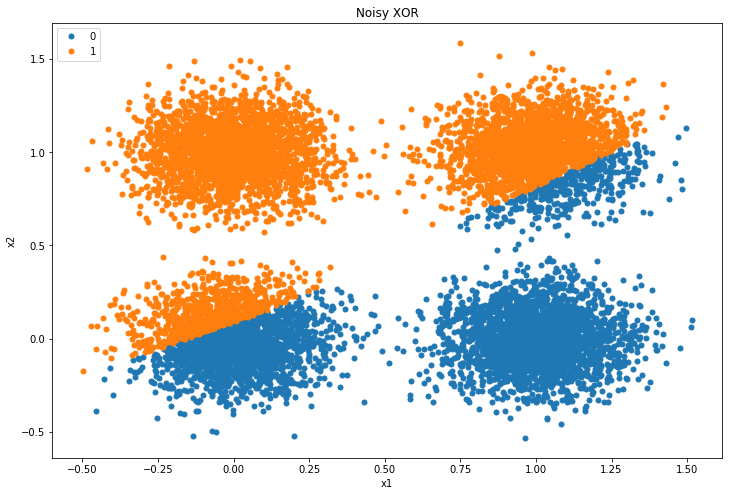

Training complete. Starting test


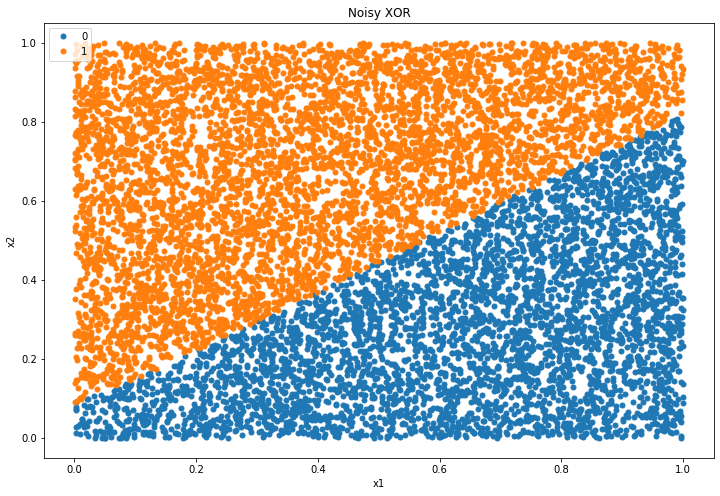

In [475]:
# Try with different loss function, I tried the softminus function
# I found the softminus function here: https://jiafulow.github.io/blog/2019/07/11/softplus-and-softminus/
# Generate Clean data 
print("Part E")
data = pd.DataFrame(np.zeros((10000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    y = 1.0 * np.logical_xor(x1==1,x2==1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y

# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

for hidden_units in [3, 16, 512]:
    W = np.random.random((2,hidden_units)) - .5
    c = .1 * np.random.random((hidden_units, 1))
    w = np.random.random((hidden_units, 1)) - .5
    b = .1 * np.random.random()
    lr = .00000001
    iters = 100
    print("Training with hidden units %s and learning rate %s" %(hidden_units, lr))
    W, c, w, b = gradientDescent(X, y, W, c, w, b, iters, 32, lr)
    loss = np.zeros(X.shape[0])
    y_predict= np.zeros(X.shape[0])
    
    for i in range(X.shape[0]):
        h, z, loss[i] = forward_propagation(np.transpose(X[i, :]), y[i], W, c, w, b)
        y_predict[i] = sigma(z)
    plot_data(X, y_predict)
    
    print("Training complete. Starting test")
    X_plot = np.matrix(np.random.random((10000, 2)))
    y_plot = np.zeros(10000)
    for i in range(X_plot.shape[0] - 1):
        h, z, L = forward_propagation(np.transpose(X_plot[i, :]), y_plot[i], W, c, w, b)
        y_plot[i] = sigma(z)
    plot_data(X_plot, y_plot)

So, the softminus turned out to be a bad loss function as the data is uniformly classified, although it is quite odd as changing the number of hidden units switches which direction that it is classified. Although, it does show improvement by adding hidden units, so I suppose it is probably a random quirk resulting in the additional 1 in the derivative.